In [10]:
import os
import pydicom
import numpy as np

import os
import pydicom
import numpy as np

def process_dicom_file(input_filepath, output_filepath, hu_range=(-10000, 3000)):
    """
    Preprocess a single DICOM file:
      - Read the DICOM file.
      - Convert raw pixel data to Hounsfield Units (HU).
      - Clip the HU values to the specified range.
      - Update the DICOM dataset (including windowing parameters) and save it.
    """
    ds = pydicom.dcmread(input_filepath)

    # Convert original pixel data to float for HU computation
    pixel_array = ds.pixel_array.astype(np.float32)
    
    # Handle slope/intercept if present, defaulting to 1 and 0 otherwise
    rescale_slope = float(ds.get('RescaleSlope', 1))
    rescale_intercept = float(ds.get('RescaleIntercept', 0))

    # Convert to Hounsfield Units
    hu_array = pixel_array * rescale_slope + rescale_intercept

    # Clip to the desired HU range
    hu_array = np.clip(hu_array, hu_range[0], hu_range[1])

    # Convert back to int16 for storage
    clipped_pixels = hu_array.astype(np.int16)

    # Update the dataset's pixel data
    ds.PixelData = clipped_pixels.tobytes()

    ds.PixelRepresentation = 1  # 1 = signed integers

    # Finally, save the modified DICOM
    ds.save_as(output_filepath)


def process_dicom_folder(input_folder, output_folder, hu_range=(-10000, 3000)):
    """
    Process all DICOM files in the input folder and save the preprocessed files to the output folder.
    
    Parameters:
        input_folder (str): Directory containing the original DICOM files.
        output_folder (str): Directory where the processed DICOM files will be saved.
        hu_range (tuple): HU clipping range.
    """
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over all files in the input folder
    for filename in os.listdir(input_folder):
        # Here we assume DICOM files have a .dcm extension; adjust if necessary
        if filename.lower().endswith('.dcm'):
            input_filepath = os.path.join(input_folder, filename)
            output_filepath = os.path.join(output_folder, filename)
            try:
                process_dicom_file(input_filepath, output_filepath, hu_range)
            except Exception as e:
                print(f"Failed to process {filename}: {e}")

if __name__ == "__main__":
    # Define your input and output directories
    input_folder = "../data/raw/CBCT"
    output_folder = "../data/process/CBCT"

    # Define the HU range for clipping
    hu_range = (-1000, 3000)

    # Process all DICOM files in the input folder
    process_dicom_folder(input_folder, output_folder, hu_range)


Failed to process RS.1.2.246.352.205.4674250585070579665.1558976644627265168.dcm: The dataset has no 'Pixel Data', 'Float Pixel Data' or 'Double Float Pixel Data' element, no pixel data to decode


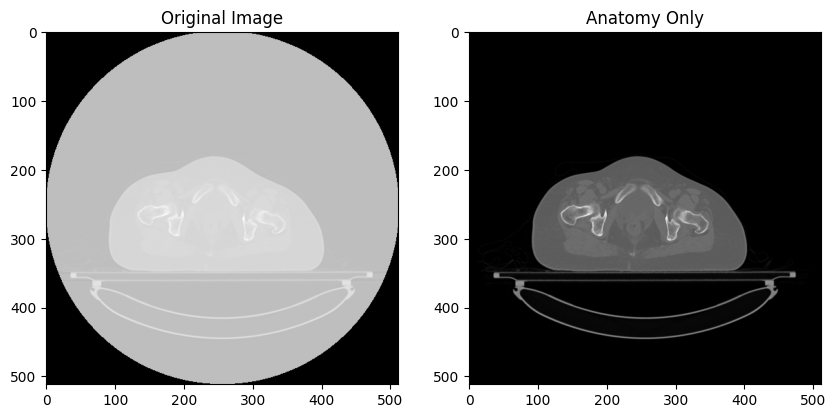

In [7]:
import pydicom
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load DICOM file
dicom_path_raw =  "../data/raw/CT/CT.1.2.246.352.221.4704010513849417296.2342682064157111716.dcm"
dicom_data_raw = pydicom.dcmread(dicom_path_raw)

# Extract pixel data
image_raw = dicom_data_raw.pixel_array

dicom_path_hf =  "../data/process/CT/CT.1.2.246.352.221.4704010513849417296.2342682064157111716.dcm"
dicom_data_hf = pydicom.dcmread(dicom_path_hf)

# Extract pixel data
image_hf = dicom_data_hf.pixel_array


# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_raw, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Anatomy Only")
plt.imshow(image_hf, cmap="gray")
plt.show()